In [1]:
###Import required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
###Specify if figures are to be saved to PNG
save_figs = True

###Color palette
orders = ['Open Loop', 'Open Loop Intermediate', 'Negative Gene Loop', 'Negative Metabolic Loop', 'Layered Negative Metabolic Loop']
palette = {'Open Loop': sns.color_palette()[3], 'Open Loop Intermediate': 'tab:purple', 'Negative Metabolic Loop': 'tab:green', 'Negative Gene Loop': 'tab:orange', 'Layered Negative Metabolic Loop': 'tab:blue', 'Initial':'black'}

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/matplotlib/transforms.py:740: UserWarning: Warning: converting a masked element to nan.
  points = np.asarray(points, float)
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


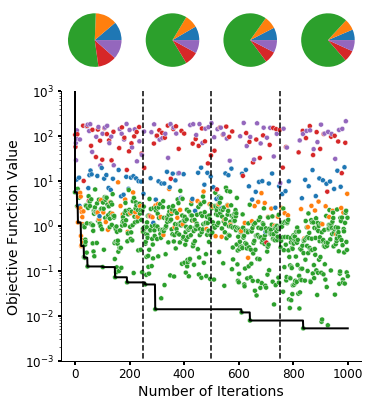

In [6]:
###FIGURE: Sample results
landscape = pd.read_csv('../data/fatty_acid_sample_run.csv')
fig = plt.figure(figsize=(5.25,5.75 ))
gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 4], width_ratios=[1, 1, 1, 1])

ax = fig.add_subplot(gs[1, :])
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_ylabel('Objective Function Value', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([10E-4, 10E2])
sns.scatterplot(x='index', y='loss', hue='circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False, s=25)
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')

prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color='k', linewidth=2)
ax.vlines(0, landscape.best_losses[starts], 10E9, color='k', linewidth=2)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

quarter1 = (landscape.iloc[0:250].sort_values(by='circuit').groupby('circuit').count().loss/250).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='circuit').groupby('circuit').count().loss/250).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='circuit').groupby('circuit').count().loss/250).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='circuit').groupby('circuit').count().loss/250).reset_index()
colors = ['tab:blue', 'tab:orange', 'tab:green', sns.color_palette()[3], 'tab:purple']

ax = fig.add_subplot(gs[0, 0])
ax.pie(quarter1.loss, colors=colors)

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter2.loss, colors=colors)

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter3.loss, colors=colors)

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter4.loss, colors=colors)

fig.tight_layout()
if save_figs: fig.savefig('../figs/fatty_acid_sample_run.png', dpi=300)


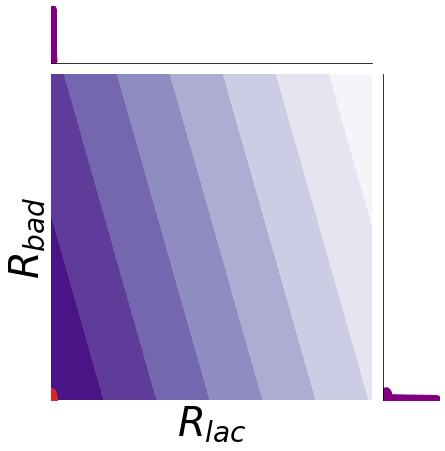

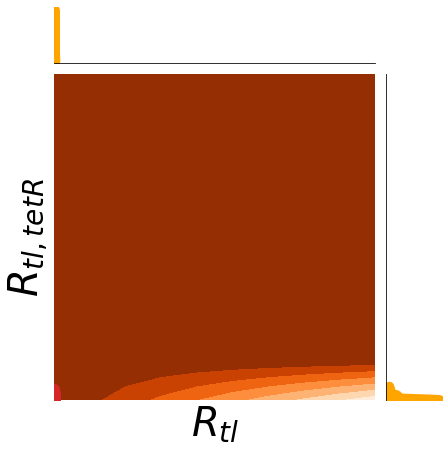

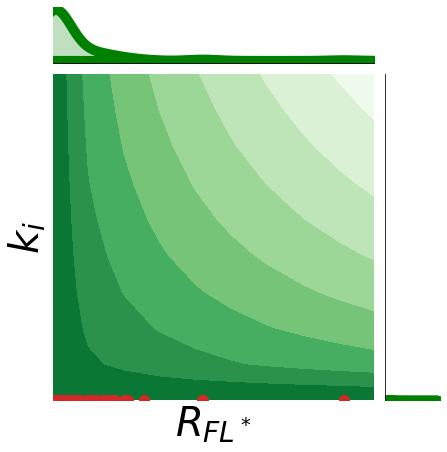

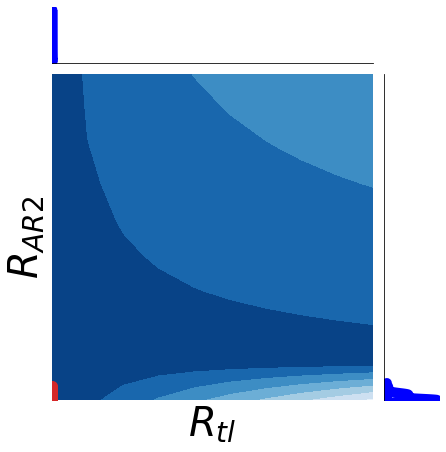

In [10]:
###FIGURE: Landscape with BayesOpt results
landscape_grid = pd.read_csv('../data/fatty_acid_landscapes_grid_search.csv')
total_landscape = pd.read_csv('../data/fatty_acid_background_singlearch.csv')

#fig, axs = plt.subplots(1,4,figsize=(8, 2))
colors = ['Purples_r','Oranges_r','Greens_r', 'Blues_r']
archs = orders[1:]
singlecolors = ['purple', 'orange', 'green', 'blue']
xs_names = ['$R_{lac}$', '$R_{tl}$', '$R_{FL^*}$', '$R_{tl}$']
ys_names = ['$R_{bad}$', r'$R_{tl, tetR}$', r'$k_i$', r'$R_{AR2}$']

xs_actual = ['r_lac_oli', 'r_tl_ngl', 'r_fl_prime_nml', 'r_tl_lnml']
ys_actual = ['r_bad_oli', 'r_tl_tetR_ngl', 'ki_nml', 'r_ar2_lnml']
for i in range(4):
    landscape = landscape_grid.loc[landscape_grid.architecture == archs[i]]
    bayesopt = total_landscape.loc[total_landscape.circuit == archs[i]]
    param1s = landscape.param1.unique()
    param2s = landscape.param2.unique()
    loss_landscape = landscape.pivot_table(index='param1', columns='param2', values='loss').T.values
    #ax = axs[i]
    

    plot_data = pd.DataFrame()
    for r in range(100):
        replicate = bayesopt.loc[bayesopt.replicate == r+1]
        pdata = replicate.loc[replicate.loss == replicate.loss.min()]
        plot_data = pd.concat([pdata, plot_data])

    #bayesopt = bayesopt.loc[bayesopt['index'].isin([499])]
    jointgrid = sns.JointGrid()

    #jointgrid = sns.jointplot(data=plot_data, x=xs_actual[i], y=ys_actual[i], kind='kde', fill=True, color=singlecolors[i])

    sns.kdeplot(data=plot_data, y=ys_actual[i], linewidth=10, ax=jointgrid.ax_marg_y, fill=True, color=singlecolors[i])
    sns.kdeplot(data=plot_data, x=xs_actual[i], linewidth=10, ax=jointgrid.ax_marg_x, fill=True, color=singlecolors[i])

    contour = jointgrid.ax_joint.contourf(param1s, param2s, loss_landscape, cmap=colors[i])
    #sns.rugplot(plot_data[xs_actual[i]], ax = jointgrid.ax_marg_x, height=1., color=singlecolors[i])
    #sns.rugplot(plot_data[ys_actual[i]], ax = jointgrid.ax_marg_y)

    #bayesopt = bayesopt.loc[bayesopt['index'].isin([499])]
    jointgrid.ax_joint.plot(plot_data[xs_actual[i]], plot_data[ys_actual[i]], 'o', color=palette['Open Loop'], markersize=10)

    #bayesopt = bayesopt.loc[bayesopt.replicate == 4]
    #ax.plot(bayesopt[xs_actual[i]], bayesopt[ys_actual[i]], 'k.')

    jointgrid.ax_joint.set_xticklabels('')
    jointgrid.ax_joint.set_yticklabels('')
    jointgrid.ax_joint.set_xlabel(xs_names[i], fontsize=40)
    jointgrid.ax_joint.set_ylabel(ys_names[i], fontsize=40)
    jointgrid.ax_joint.set_xticks([])
    jointgrid.ax_joint.set_yticks([])
    jointgrid.ax_marg_y.set_xticks([])
    jointgrid.ax_marg_y.set_yticks([])
    jointgrid.ax_marg_x.set_xticks([])
    jointgrid.ax_marg_x.set_yticks([])
    jointgrid.ax_joint.set_xlim([landscape.param1.min(), landscape.param1.max()])
    jointgrid.ax_joint.set_ylim([landscape.param2.min(), landscape.param2.max()])
    

    for spine in jointgrid.ax_joint.spines.values():
        spine.set_edgecolor(None)

    if save_figs: jointgrid.savefig('../figs/fatty_acid_single_landscape_' + archs[i].lower().replace(' ', '_') + '.png', dpi=300)
